For ease in future projects I am going to define a routine for testing real time dsp

This will only be simulated real time, feeding segments/buffers of audio into an algorythm.
routines for testing performence might come later, but are not particularly relevent in python code.

I will be able to copy and paste code from here

In [12]:
import soundfile as sf
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [13]:
#opening a wav file --- our trusty sitar

audio, samplerate = sf.read('sitar.wav')
buffersize = 156

#we want to zero pad the file so that it will emulate a realtime stream
audio = np.append(audio, np.full(buffersize - (len(audio) % buffersize), 0.0))

print('samplerate = {}'.format(samplerate))
print('audio length = {} seconds'.format(len(audio)/samplerate))
print('array lenght = {} samples'.format(len(audio)))

samplerate = 11025
audio length = 2.462040816326531 seconds
array lenght = 27144 samples


In [14]:
#we can put this in a genorator

def buffer_gen(audio, buffersize):

    index = 0
    while index < len(audio):
        yield(audio[index:index+buffersize])
        index += buffersize
    return

In [15]:
#example usage

buffers = buffer_gen(audio, buffersize)

output = np.empty(0)

for buffer in buffers:
    output = np.append(output, buffer)
    
if np.all(output == audio):
    print('success')


success


In [31]:
#so now we try with a real time IIR filter

class IIR_realtime():
    
    def __init__(self, b, a):

        #filter coeficiants
        self.A = a
        self.B = b / a[0]
        
        #lengths of coeficiants
        self.M = len(self.B)
        self.Q = len(self.A)
        
        self.clean_last_overlap = np.full(self.M, 0.0)
        self.last_overlap = np.full(self.M, 0.0)
        
    def proccess(self, signal):
        
        #append the last overlap and get the next ---- this is really not so efficiant
        sigLen = len(signal)
        
        signal = np.append(self.clean_last_overlap, signal)
        
        #convolve the signal
        output = np.append(self.last_overlap, np.full(sigLen, 0.0))

        for N in range(self.M, len(signal)):

            output[N] = self.B[0] * signal[N]

            for K in range(1, self.M):

                feedback = (self.A[K] * output[N-K])

                output[N] += (self.B[K] * signal[N - K]) - feedback
                
        self.clean_last_overlap = signal[sigLen:]
        self.last_overlap = output[sigLen:]
        print(self.last_overlap)
        
        output = output[:sigLen]
        '''
        plt.plot(signal)
        plt.show()
        
        plt.plot(output)
        plt.show()
        
        plt.plot(self.last_overlap)
        plt.show()
        
        plt.plot(self.clean_last_overlap)
        plt.show()
        '''
        
        return output
        
    def set_coefs(self, b, a):
        #in this implementation can't change the order
        self.A = a
        self.B = b
        
        

[0.05720037 0.11440075 0.05720037]
[ 1.         -1.21887934  0.44768083]


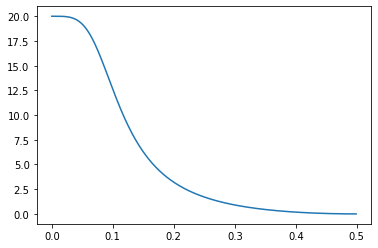

In [32]:
#a window that we can test with
order = 2
ripple = .9
cuttoff = 1000
#b, a = sig.cheby1(order, ripple, cuttoff, 'low', fs=samplerate)
b, a = sig.butter(order, cuttoff, 'low', fs=samplerate)
print(b)
print(a)
#plot this for show
w, h = sig.freqz(b, a)
plt.plot(w/np.pi/2, 20 * np.abs(h))
plt.show()

In [33]:
filt = IIR_realtime(b, a)

buffers = buffer_gen(audio, buffersize)

output = np.empty(0)

for buffer in buffers:
    buffer = filt.proccess(buffer)
    output = np.append(output, buffer)


[ 0.2030541   0.09127857 -0.03595248]
[0.03947947 0.02257726 0.00761037]
[0.12685879 0.14127525 0.10736143]
[0.0465861  0.16583956 0.24652688]
[0.22141507 0.28185428 0.25648878]
[0.12415198 0.15321342 0.16110903]
[-0.10612955 -0.09517747 -0.0926291 ]
[-0.08907531 -0.03917856  0.00195468]
[-0.07860483 -0.03858971 -0.0122932 ]
[-0.36731286 -0.34425569 -0.27080794]
[-0.19176251 -0.24836306 -0.22045122]
[-0.02016408 -0.03140984 -0.02300144]
[-0.05440088 -0.10296711 -0.11902537]
[0.02678715 0.06190946 0.09028074]
[0.08620837 0.12399493 0.13667243]
[-0.01077937 -0.03107332 -0.06030846]
[ 0.19424462  0.10508375 -0.01830994]
[-0.01141591 -0.05651282 -0.08522176]
[0.08950956 0.11368401 0.14899258]
[-0.04742771 -0.0673935  -0.07699968]
[-0.16985129 -0.26589326 -0.31910622]
[-0.18474956 -0.16634534 -0.12406797]
[0.20953969 0.21194097 0.16273605]
[0.09893826 0.1521694  0.160846  ]
[0.19129314 0.14934688 0.08522561]
[ 0.0615667   0.01770698 -0.06183929]
[0.43253818 0.40844493 0.32654993]
[0.2199799

The Original Audio


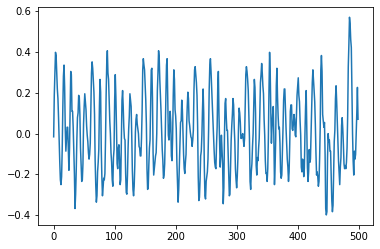

In [34]:
print('The Original Audio')
plt.plot(audio[:500])
plt.show()
display(Audio(audio, rate=samplerate))

The Filtered Audio


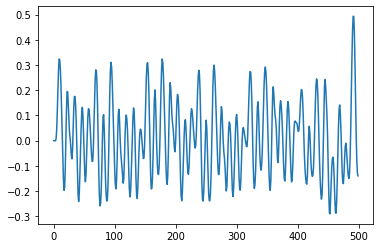

In [35]:
print('The Filtered Audio')
plt.plot(output[:500])
plt.show()
display(Audio(output, rate=samplerate))

## It works!!

so lets try a low pass sweep to show off real time capabilities

In [41]:


buffers = buffer_gen(audio, buffersize)

output = np.empty(0)

order = 10
ripple = .001
cutoff_max = 2500
cutoff_min = 100
cutcount = cutoff_min

filt = IIR_realtime(b, a)

for buffer in buffers:
    

    cutcount += 10
    cuttoff = (cutcount % (cutoff_max - cutoff_min)) + cutoff_min
    #print(cuttoff)

    #b, a = sig.cheby1(order, ripple, cuttoff, 'low', fs=samplerate)
    b, a = sig.butter(order, cuttoff, 'low', fs=samplerate)
    filt.set_coefs(b, a)
    
    buffer = filt.proccess(buffer)
    output = np.append(output, buffer)



[-0.01539776 -0.01707016 -0.01860626 -0.020003   -0.02126034 -0.02238112
 -0.02337086 -0.02423752 -0.02499127 -0.02564413 -0.02620968]
[ 0.0059721   0.00356705  0.00118292 -0.00114619 -0.00338909 -0.00551806
 -0.00750937 -0.00934365 -0.01100617 -0.01248703 -0.0137812 ]
[0.01972643 0.01889365 0.01784365 0.01658738 0.01513988 0.01351985
 0.01174913 0.00985208 0.00785488 0.00578479 0.00366938]
[-0.09582379 -0.09227547 -0.08796862 -0.08296459 -0.07733093 -0.07113994
 -0.06446712 -0.05738962 -0.04998488 -0.04232922 -0.03449675]
[-0.02090005 -0.02641838 -0.03111695 -0.03494525 -0.03787005 -0.03987552
 -0.04096288 -0.04114969 -0.04046888 -0.03896735 -0.03670439]
[ 0.00790901 -0.00420501 -0.01649487 -0.02878788 -0.04091182 -0.05269794
 -0.06398392 -0.07461663 -0.0844547  -0.09337085 -0.10125389]
[0.10189341 0.10541635 0.10764483 0.10856966 0.10820247 0.1065752
 0.10373942 0.09976538 0.09474069 0.08876885 0.0819674 ]
[0.02342553 0.03109489 0.03882015 0.04642045 0.05371691 0.06053597
 0.0667126 

  0.21266668  0.30475867  0.37414488  0.41434005  0.42124214]
[-0.53978043 -0.50025142 -0.41961268 -0.31477132 -0.19475872 -0.0611823
  0.08474521  0.23380338  0.36531619  0.45192797  0.47058422]
[-0.45599245 -0.35184968 -0.21396407 -0.06226961  0.08226843  0.19902704
  0.27009507  0.28466421  0.24420427  0.16485438  0.07368744]
[-0.23911806 -0.12979145 -0.02445938  0.03981372  0.04562448 -0.00105681
 -0.07644242 -0.14981986 -0.19430471 -0.19349818 -0.1431938 ]
[-0.22034413 -0.19179317 -0.11769298 -0.01355588  0.0904598   0.15953487
  0.16826758  0.11276203  0.01475051 -0.08506609 -0.14234474]
[ 0.07691599 -0.08986749 -0.2653327  -0.41367604 -0.50589399 -0.52875201
 -0.48706    -0.39943938 -0.29050956 -0.18268248 -0.08964357]
[ 0.30729232  0.28130003  0.21834494  0.123456    0.01357441 -0.08717414
 -0.15671222 -0.18342447 -0.1695108  -0.12851464 -0.07919753]
[ 0.57451974  0.4854125   0.29305802  0.04734921 -0.19156142 -0.37603771
 -0.48409193 -0.51789751 -0.49183042 -0.41972361 -0.3097

The Filtered Audio


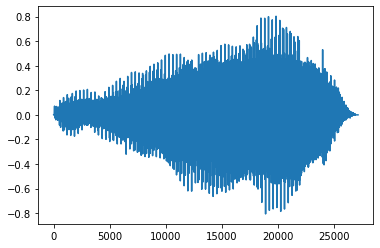

In [39]:
print('The Filtered Audio')
plt.plot(output)
plt.show()
display(Audio(output, rate=samplerate))

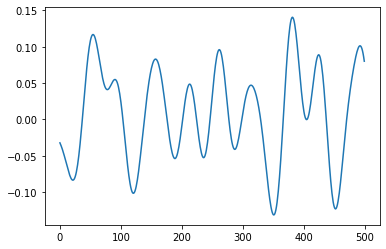

In [40]:
plt.plot(output[500:1000])